In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Number of classes: 4, Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class weights: tensor([1.0807, 1.0665, 0.8952, 0.9805], device='cuda:0')

=== Epoch 1/5 ===
Train - Loss: 0.2765, Accuracy: 0.9011, Precision: 0.9014, Recall: 0.9011, F1: 0.9011
Val   - Loss: 0.1472, Accuracy: 0.9493, Precision: 0.9565, Recall: 0.9493, F1: 0.9504, ROC-AUC: 0.9977

=== Epoch 2/5 ===
Train - Loss: 0.1074, Accuracy: 0.9634, Precision: 0.9635, Recall: 0.9634, F1: 0.9635
Val   - Loss: 0.0805, Accuracy: 0.9781, Precision: 0.9783, Recall: 0.9781, F1: 0.9781, ROC-AUC: 0.9990

=== Epoch 3/5 ===
Train - Loss: 0.0582, Accuracy: 0.9814, Precision: 0.9814, Recall: 0.9814, F1: 0.9814
Val   - Loss: 0.0698, Accuracy: 0.9825, Precision: 0.9827, Recall: 0.9825, F1: 0.9825, ROC-AUC: 0.9990

=== Epoch 4/5 ===
Train - Loss: 0.0460, Accuracy: 0.9853, Precision: 0.9853, Recall: 0.9853, F1: 0.9853
Val   - Loss: 0.0850, Accuracy: 0.9764, Precision: 0.9768, Recall: 0.9764, F1: 0.9764, ROC-AUC: 0.9979

=== Epoch 5/5 

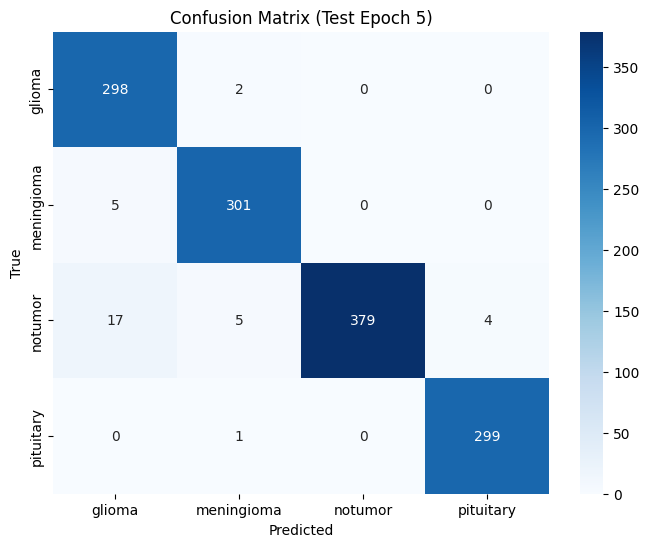

Test  - Loss: 0.0877, Accuracy: 0.9741, Precision: 0.9752, Recall: 0.9741, F1: 0.9741, ROC-AUC: 0.9995
Per-Class Metrics (Test):
glioma - Precision: 0.9313, Recall: 0.9933, F1: 0.9613
meningioma - Precision: 0.9741, Recall: 0.9837, F1: 0.9789
notumor - Precision: 1.0000, Recall: 0.9358, F1: 0.9668
pituitary - Precision: 0.9868, Recall: 0.9967, F1: 0.9917

==================== Final Test Evaluation ====================


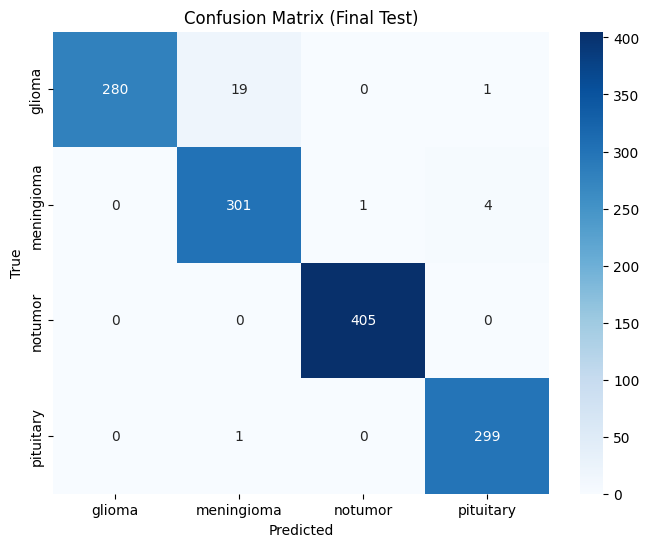

Test Metrics - Loss: 0.0665, Accuracy: 0.9802, Precision: 0.9809, Recall: 0.9802, F1: 0.9801, ROC-AUC: 0.9992

Per-Class Metrics (Test):
glioma - Precision: 1.0000, Recall: 0.9333, F1: 0.9655
meningioma - Precision: 0.9377, Recall: 0.9837, F1: 0.9601
notumor - Precision: 0.9975, Recall: 1.0000, F1: 0.9988
pituitary - Precision: 0.9836, Recall: 0.9967, F1: 0.9901


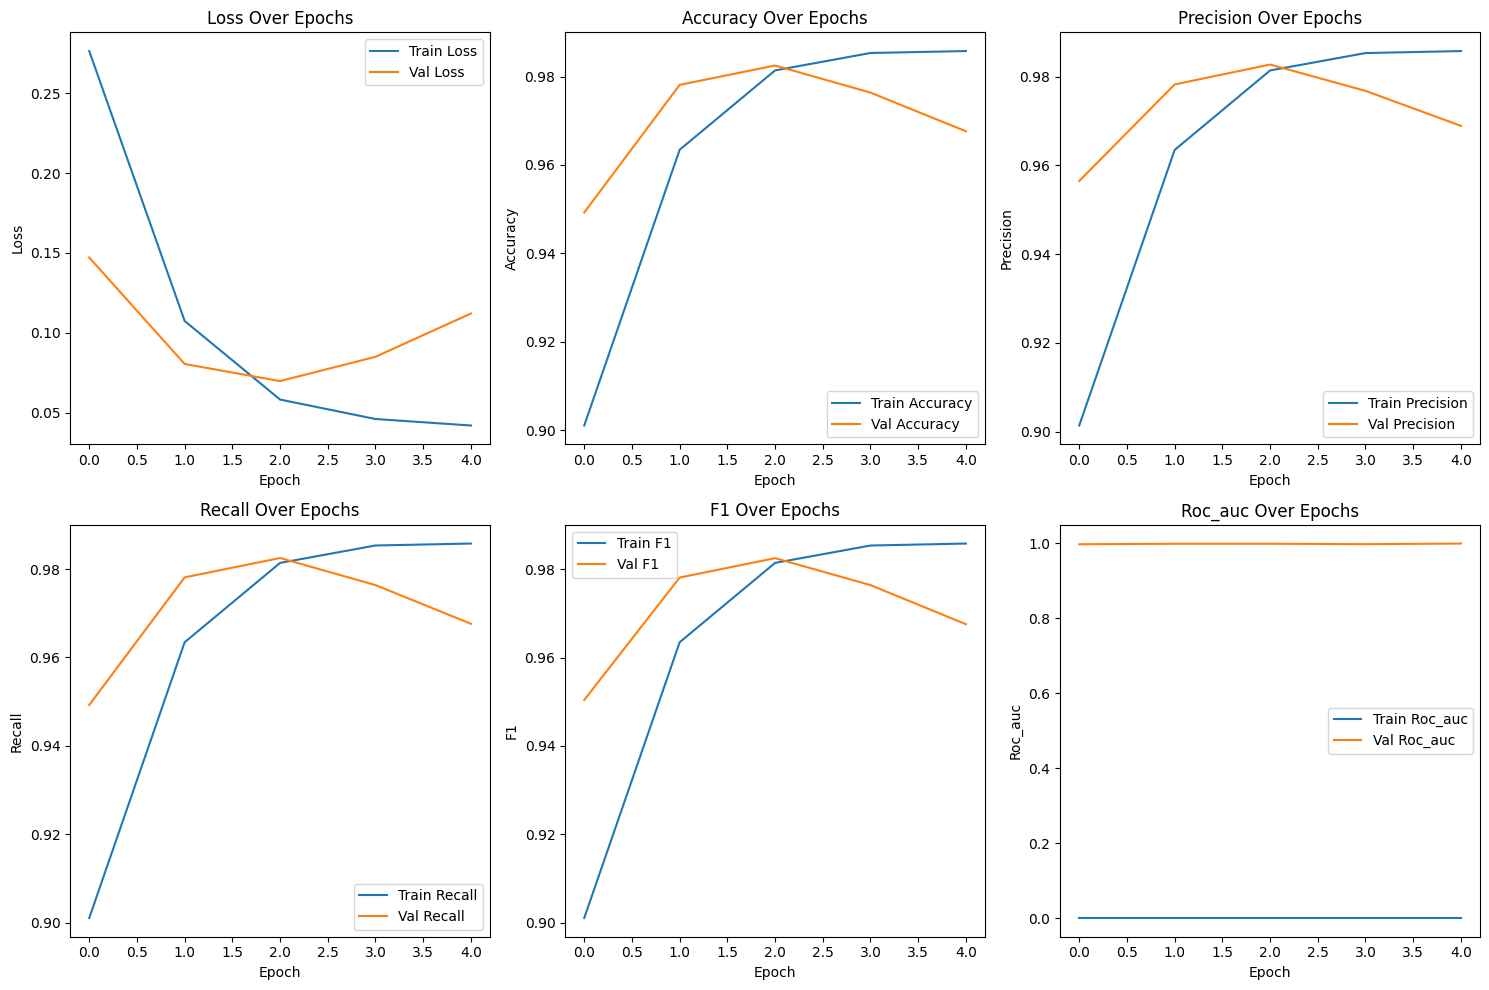

In [13]:
# Install required packages
!pip install -U scikit-learn  # Update scikit-learn
!pip install timm  # Install timm for Swin Transformer

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import timm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Create /kaggle/working directory if it doesn't exist
os.makedirs("/kaggle/working", exist_ok=True)

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
data_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Handle grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split training data into train and validation
indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[train_dataset.targets[i] for i in indices], random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get number of classes
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Number of classes: {num_classes}, Classes: {class_names}")

# Compute class weights for imbalanced dataset
class_counts = Counter([train_dataset.targets[i] for i in train_idx])
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (num_classes * class_counts[i]) for i in range(num_classes)], dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

# Initialize Swin Transformer model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Function to compute metrics
def compute_metrics(model, loader, is_test=False, phase="Evaluation"):
    model.eval()
    all_preds, all_labels, losses, all_probs = [], [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    # Core metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_loss = np.mean(losses)

    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # ROC-AUC (one-vs-rest, weighted)
    try:
        all_probs = np.array(all_probs)
        all_labels_one_hot = np.zeros((len(all_labels), num_classes))
        for i, label in enumerate(all_labels):
            all_labels_one_hot[i, label] = 1
        roc_auc = roc_auc_score(all_labels_one_hot, all_probs, average='weighted', multi_class='ovr')
    except:
        roc_auc = 0.0  # Fallback if ROC-AUC fails

    # Confusion matrix (for test set or on demand)
    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix ({phase})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f"/kaggle/working/confusion_matrix_{phase.lower().replace(' ', '_')}.png")
        plt.show()

    return (accuracy, precision, recall, f1, avg_loss, roc_auc,
            per_class_precision, per_class_recall, per_class_f1)

# Training loop with mid-training test evaluation
num_epochs = 5  # Changed to 5 epochs
train_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
best_recall = 0.0
best_model_path = "/kaggle/working/swin_transformer_best.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(0.0)  # ROC-AUC computed only for val/test

    # Validation
    (val_accuracy, val_precision, val_recall, val_f1, val_loss, val_roc_auc,
     _, _, _) = compute_metrics(model, val_loader, phase="Validation")
    val_metrics['loss'].append(val_loss)
    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Save best model based on validation recall
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), best_model_path)

    # Step scheduler
    scheduler.step(val_loss)

    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

    # Mid-training test evaluation (at epoch 5)
    if (epoch + 1) % 5 == 0:
        print(f"\n--- Mid-Training Test Evaluation (Epoch {epoch+1}) ---")
        (test_accuracy, test_precision, test_recall, test_f1, test_loss, test_roc_auc,
         test_per_class_precision, test_per_class_recall, test_per_class_f1) = compute_metrics(model, test_loader, is_test=True, phase=f"Test Epoch {epoch+1}")
        print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
        print("Per-Class Metrics (Test):")
        for i, class_name in enumerate(class_names):
            print(f"{class_name} - Precision: {test_per_class_precision[i]:.4f}, Recall: {test_per_class_recall[i]:.4f}, F1: {test_per_class_f1[i]:.4f}")

# Final evaluation phase on test set
print("\n==================== Final Test Evaluation ====================")
model.load_state_dict(torch.load(best_model_path))
(test_accuracy, test_precision, test_recall, test_f1, test_loss, test_roc_auc,
 test_per_class_precision, test_per_class_recall, test_per_class_f1) = compute_metrics(model, test_loader, is_test=True, phase="Final Test")

# Print final test metrics
print(f"Test Metrics - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
print("\nPer-Class Metrics (Test):")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {test_per_class_precision[i]:.4f}, Recall: {test_per_class_recall[i]:.4f}, F1: {test_per_class_f1[i]:.4f}")

# Plot metrics
plt.figure(figsize=(15, 10))
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(train_metrics[metric], label=f"Train {metric.capitalize()}")
    plt.plot(val_metrics[metric], label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/training_metrics.png")
plt.show()

# Save final model
torch.save(model.state_dict(), "/kaggle/working/swin_transformer_final.pth")

Number of classes: 4, Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class weights: tensor([1.0807, 1.0665, 0.8952, 0.9805])

=== Epoch 1/10 ===
Train - Loss: 0.8619, Accuracy: 0.6163, Precision: 0.6223, Recall: 0.6163, F1: 0.6167
Val   - Loss: 0.9072, Accuracy: 0.5748, Precision: 0.6798, Recall: 0.5748, F1: 0.5634, ROC-AUC: 0.8997

=== Epoch 2/10 ===
Train - Loss: 0.6414, Accuracy: 0.7365, Precision: 0.7353, Recall: 0.7365, F1: 0.7359
Val   - Loss: 1.2617, Accuracy: 0.5031, Precision: 0.5995, Recall: 0.5031, F1: 0.4594, ROC-AUC: 0.8622

=== Epoch 3/10 ===
Train - Loss: 0.5778, Accuracy: 0.7621, Precision: 0.7615, Recall: 0.7621, F1: 0.7615
Val   - Loss: 1.1323, Accuracy: 0.6028, Precision: 0.7256, Recall: 0.6028, F1: 0.5763, ROC-AUC: 0.8911

=== Epoch 4/10 ===
Train - Loss: 0.5024, Accuracy: 0.8052, Precision: 0.8051, Recall: 0.8052, F1: 0.8045
Val   - Loss: 0.9063, Accuracy: 0.6877, Precision: 0.7653, Recall: 0.6877, F1: 0.6898, ROC-AUC: 0.9276

=== Epoch 5/10 ===
Train - 

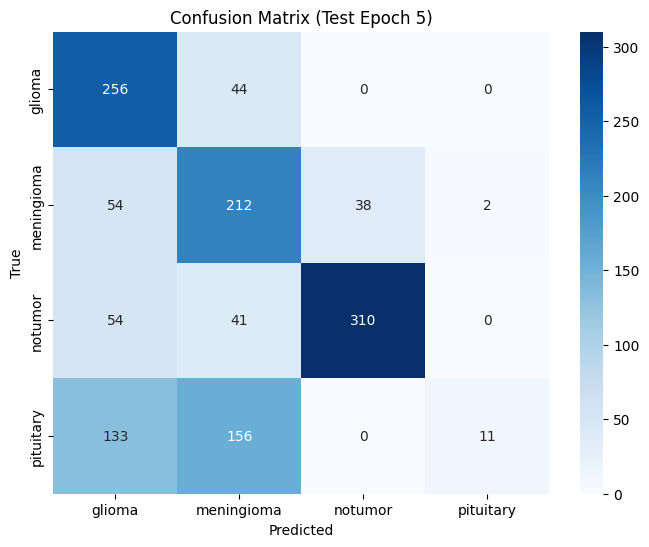

Test  - Loss: 1.5194, Accuracy: 0.6018, Precision: 0.6959, Recall: 0.6018, F1: 0.5478, ROC-AUC: 0.9033
Per-Class Metrics (Test):
glioma - Precision: 0.5151, Recall: 0.8533, F1: 0.6424
meningioma - Precision: 0.4680, Recall: 0.6928, F1: 0.5586
notumor - Precision: 0.8908, Recall: 0.7654, F1: 0.8234
pituitary - Precision: 0.8462, Recall: 0.0367, F1: 0.0703

=== Epoch 6/10 ===
Train - Loss: 0.4147, Accuracy: 0.8420, Precision: 0.8442, Recall: 0.8420, F1: 0.8423
Val   - Loss: 0.6803, Accuracy: 0.7235, Precision: 0.8288, Recall: 0.7235, F1: 0.7282, ROC-AUC: 0.9591

=== Epoch 7/10 ===
Train - Loss: 0.3859, Accuracy: 0.8551, Precision: 0.8562, Recall: 0.8551, F1: 0.8551
Val   - Loss: 0.5438, Accuracy: 0.7655, Precision: 0.8577, Recall: 0.7655, F1: 0.7736, ROC-AUC: 0.9739

=== Epoch 8/10 ===
Train - Loss: 0.3717, Accuracy: 0.8560, Precision: 0.8584, Recall: 0.8560, F1: 0.8560
Val   - Loss: 0.6284, Accuracy: 0.7979, Precision: 0.8510, Recall: 0.7979, F1: 0.7986, ROC-AUC: 0.9646

=== Epoch 9/10 

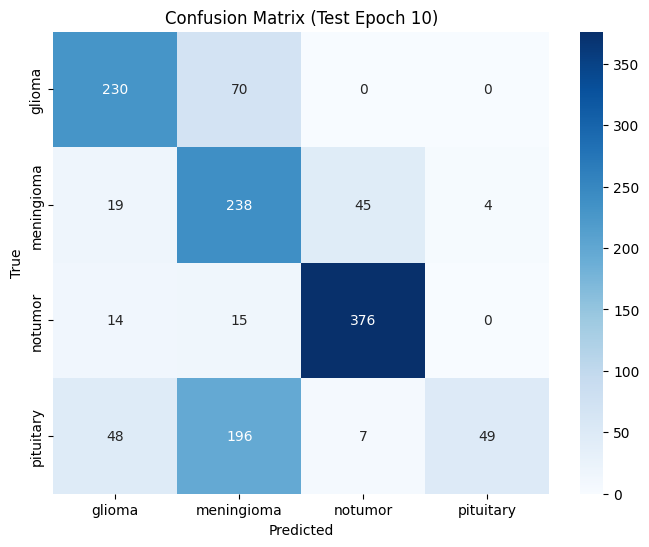

Test  - Loss: 0.9967, Accuracy: 0.6812, Precision: 0.7592, Recall: 0.6812, F1: 0.6494, ROC-AUC: 0.9315
Per-Class Metrics (Test):
glioma - Precision: 0.7395, Recall: 0.7667, F1: 0.7529
meningioma - Precision: 0.4586, Recall: 0.7778, F1: 0.5770
notumor - Precision: 0.8785, Recall: 0.9284, F1: 0.9028
pituitary - Precision: 0.9245, Recall: 0.1633, F1: 0.2776

==================== Final Test Evaluation ====================


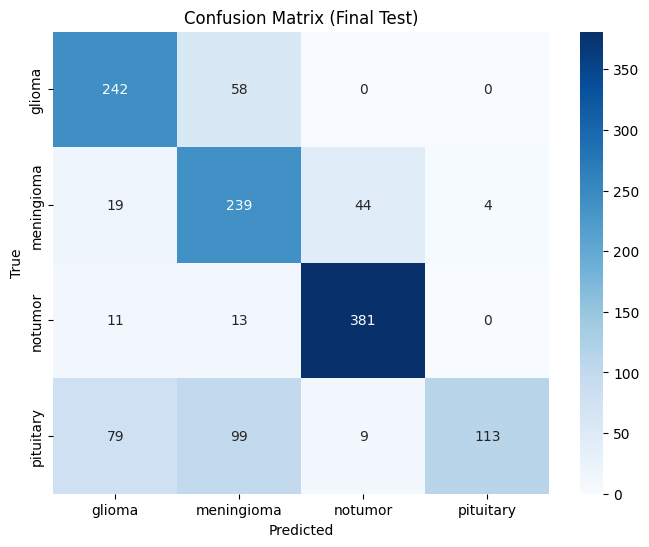

Test Metrics - Loss: 0.8590, Accuracy: 0.7437, Precision: 0.7864, Recall: 0.7437, F1: 0.7308, ROC-AUC: 0.9480

Per-Class Metrics (Test):
glioma - Precision: 0.6895, Recall: 0.8067, F1: 0.7435
meningioma - Precision: 0.5844, Recall: 0.7810, F1: 0.6685
notumor - Precision: 0.8779, Recall: 0.9407, F1: 0.9082
pituitary - Precision: 0.9658, Recall: 0.3767, F1: 0.5420


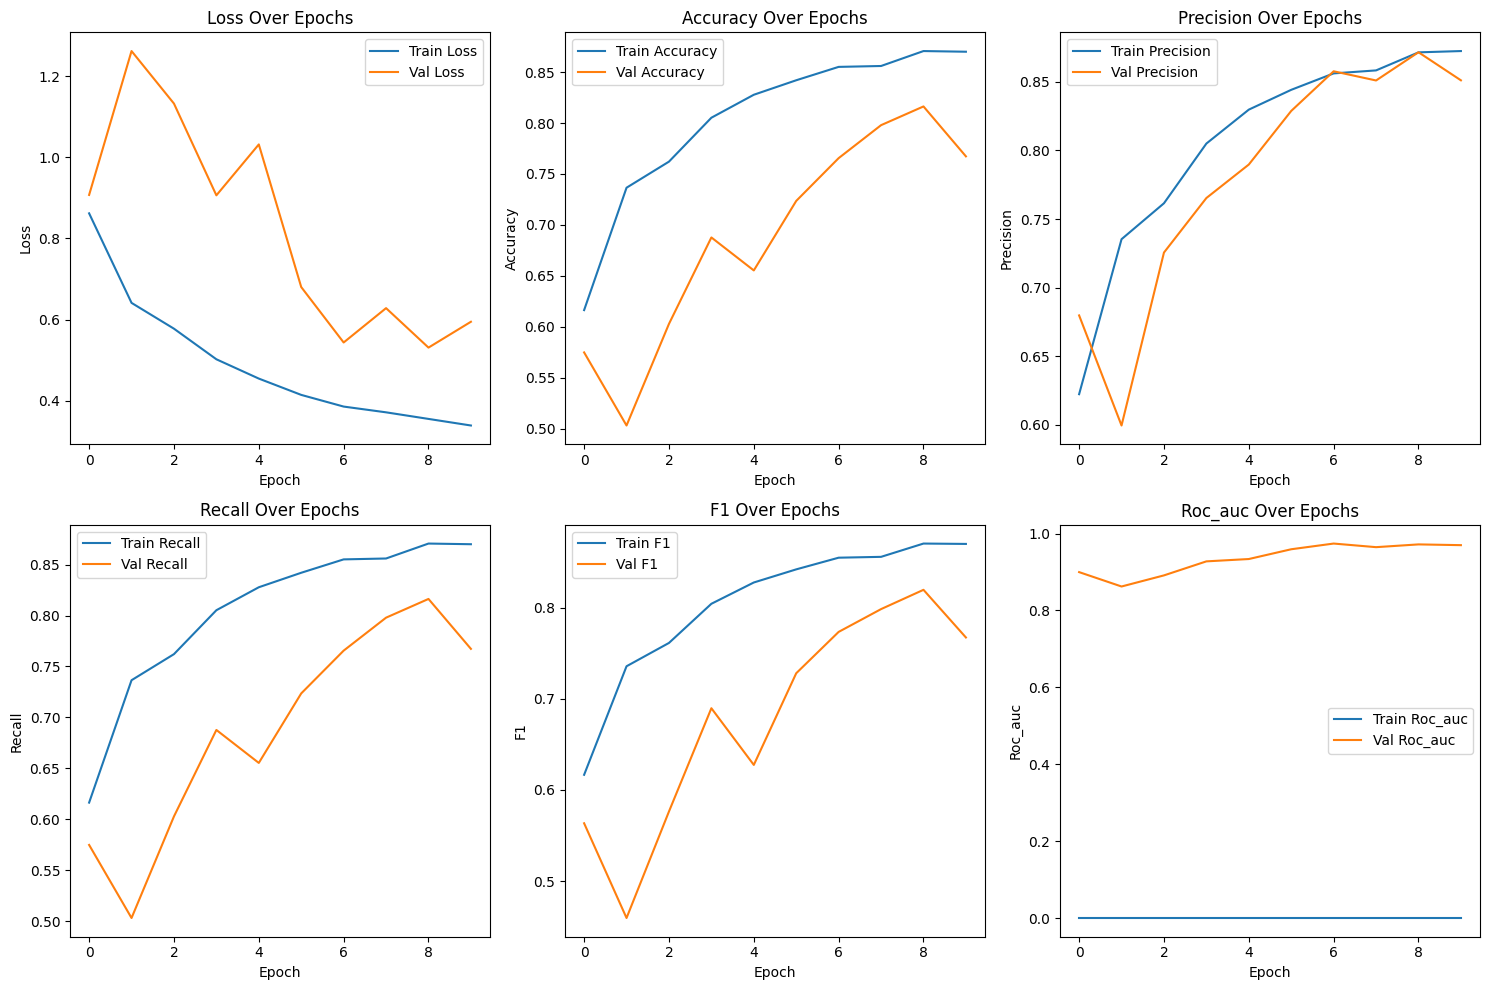

In [16]:
# Install required packages
!pip install -U scikit-learn  # Update scikit-learn

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, WeightedRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Create /kaggle/working directory if it doesn't exist
os.makedirs("/kaggle/working", exist_ok=True)

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
data_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")

# Data transformations with enhanced augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Handle grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split training data into train and validation
indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[train_dataset.targets[i] for i in indices], random_state=42)

# WeightedRandomSampler for training to handle class imbalance
class_counts = Counter([train_dataset.targets[i] for i in train_idx])
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))], dtype=torch.float)
weights = [class_weights[train_dataset.targets[i]] for i in train_idx]
train_sampler = WeightedRandomSampler(weights, len(weights))

val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get number of classes
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Number of classes: {num_classes}, Classes: {class_names}")
print(f"Class weights: {class_weights}")

# Define pure CNN model
class PureCNN(nn.Module):
    def __init__(self, num_classes):
        super(PureCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Initialize CNN model
model = PureCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Function to compute metrics with threshold tuning
def compute_metrics(model, loader, is_test=False, phase="Evaluation", recall_threshold=0.3):
    model.eval()
    all_preds, all_labels, losses, all_probs = [], [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            # Threshold tuning for higher recall
            preds = torch.argmax(probs, dim=1)
            for i in range(len(probs)):
                if torch.max(probs[i, 1:]) > recall_threshold:
                    preds[i] = torch.argmax(probs[i, 1:]) + 1
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Core metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_loss = np.mean(losses)

    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # ROC-AUC
    try:
        all_probs = np.array(all_probs)
        all_labels_one_hot = np.zeros((len(all_labels), num_classes))
        for i, label in enumerate(all_labels):
            all_labels_one_hot[i, label] = 1
        roc_auc = roc_auc_score(all_labels_one_hot, all_probs, average='weighted', multi_class='ovr')
    except:
        roc_auc = 0.0

    # Confusion matrix
    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix ({phase})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f"/kaggle/working/confusion_matrix_{phase.lower().replace(' ', '_')}.png")
        plt.show()

    return (accuracy, precision, recall, f1, avg_loss, roc_auc,
            per_class_precision, per_class_recall, per_class_f1)

# Training loop with early stopping
num_epochs = 10  # Increased to 10 epochs
train_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
best_recall = 0.0
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
best_model_path = "/kaggle/working/cnn_best.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(0.0)

    # Validation
    (val_accuracy, val_precision, val_recall, val_f1, val_loss, val_roc_auc,
     _, _, _) = compute_metrics(model, val_loader, phase="Validation")
    val_metrics['loss'].append(val_loss)
    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Save best model based on validation recall
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), best_model_path)

    # Step scheduler
    scheduler.step(val_loss)

    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

    # Mid-training test evaluation (at epochs 5 and 10)
    if (epoch + 1) % 5 == 0:
        print(f"\n--- Mid-Training Test Evaluation (Epoch {epoch+1}) ---")
        (test_accuracy, test_precision, test_recall, test_f1, test_loss, test_roc_auc,
         test_per_class_precision, test_per_class_recall, test_per_class_f1) = compute_metrics(model, test_loader, is_test=True, phase=f"Test Epoch {epoch+1}")
        print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
        print("Per-Class Metrics (Test):")
        for i, class_name in enumerate(class_names):
            print(f"{class_name} - Precision: {test_per_class_precision[i]:.4f}, Recall: {test_per_class_recall[i]:.4f}, F1: {test_per_class_f1[i]:.4f}")

# Final evaluation phase on test set
print("\n==================== Final Test Evaluation ====================")
model.load_state_dict(torch.load(best_model_path))
(test_accuracy, test_precision, test_recall, test_f1, test_loss, test_roc_auc,
 test_per_class_precision, test_per_class_recall, test_per_class_f1) = compute_metrics(model, test_loader, is_test=True, phase="Final Test")

# Print final test metrics
print(f"Test Metrics - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
print("\nPer-Class Metrics (Test):")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {test_per_class_precision[i]:.4f}, Recall: {test_per_class_recall[i]:.4f}, F1: {test_per_class_f1[i]:.4f}")

# Plot metrics
plt.figure(figsize=(15, 10))
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(train_metrics[metric], label=f"Train {metric.capitalize()}")
    plt.plot(val_metrics[metric], label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/training_metrics.png")
plt.show()

# Save final model
torch.save(model.state_dict(), "/kaggle/working/cnn_final.pth")

Number of classes: 4, Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class weights: tensor([70.2674, 69.8066, 63.9537, 66.9311])

=== Epoch 1/10 ===
Train - Loss: 1.0314, Accuracy: 0.5349, Precision: 0.5313, Recall: 0.5349, F1: 0.5236
Val   - Loss: 1.4829, Accuracy: 0.2703, Precision: 0.4001, Recall: 0.2703, F1: 0.1559, ROC-AUC: 0.7618

=== Epoch 2/10 ===
Train - Loss: 0.8723, Accuracy: 0.6071, Precision: 0.6053, Recall: 0.6071, F1: 0.6004
Val   - Loss: 1.1986, Accuracy: 0.3097, Precision: 0.5491, Recall: 0.3097, F1: 0.2210, ROC-AUC: 0.8370

=== Epoch 3/10 ===
Train - Loss: 0.7778, Accuracy: 0.6570, Precision: 0.6562, Recall: 0.6570, F1: 0.6542
Val   - Loss: 1.0618, Accuracy: 0.4348, Precision: 0.5424, Recall: 0.4348, F1: 0.3731, ROC-AUC: 0.8668

=== Epoch 4/10 ===
Train - Loss: 0.7447, Accuracy: 0.6938, Precision: 0.6894, Recall: 0.6938, F1: 0.6904
Val   - Loss: 0.9976, Accuracy: 0.4786, Precision: 0.7400, Recall: 0.4786, F1: 0.4377, ROC-AUC: 0.8806

=== Epoch 5/10 ===
Trai

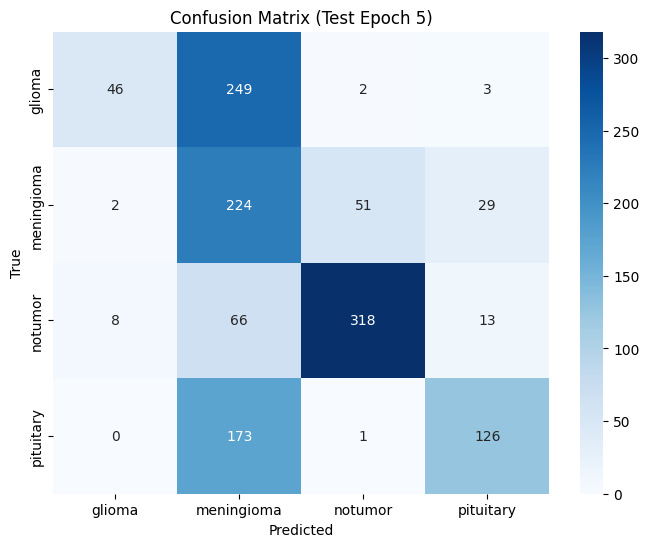

Test  - Loss: 0.8871, Accuracy: 0.5446, Precision: 0.6941, Recall: 0.5446, F1: 0.5372, ROC-AUC: 0.8862
Per-Class Metrics (Test):
glioma - Precision: 0.8214, Recall: 0.1533, F1: 0.2584
meningioma - Precision: 0.3146, Recall: 0.7320, F1: 0.4401
notumor - Precision: 0.8548, Recall: 0.7852, F1: 0.8185
pituitary - Precision: 0.7368, Recall: 0.4200, F1: 0.5350

=== Epoch 6/10 ===
Train - Loss: 0.6617, Accuracy: 0.7201, Precision: 0.7167, Recall: 0.7201, F1: 0.7181
Val   - Loss: 1.1754, Accuracy: 0.3893, Precision: 0.7076, Recall: 0.3893, F1: 0.3260, ROC-AUC: 0.8901

=== Epoch 7/10 ===
Train - Loss: 0.6375, Accuracy: 0.7325, Precision: 0.7294, Recall: 0.7325, F1: 0.7307
Val   - Loss: 0.8826, Accuracy: 0.5293, Precision: 0.7696, Recall: 0.5293, F1: 0.4970, ROC-AUC: 0.9250

=== Epoch 8/10 ===
Train - Loss: 0.6059, Accuracy: 0.7531, Precision: 0.7508, Recall: 0.7531, F1: 0.7514
Val   - Loss: 0.7949, Accuracy: 0.5748, Precision: 0.7709, Recall: 0.5748, F1: 0.5492, ROC-AUC: 0.9235

=== Epoch 9/10 

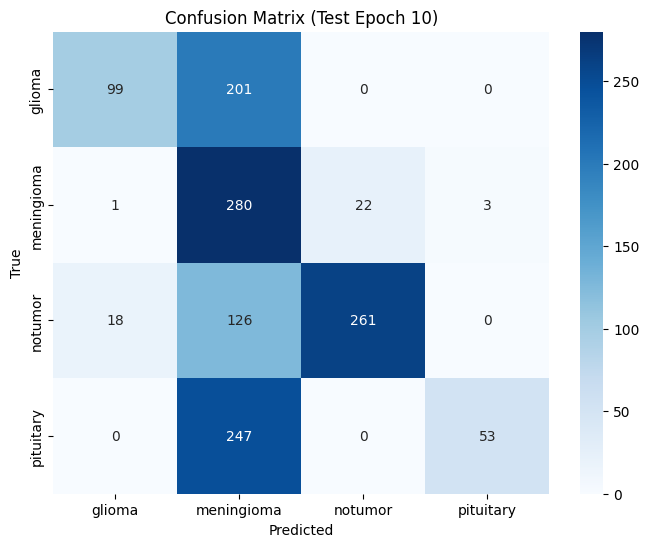

Test  - Loss: 1.2039, Accuracy: 0.5286, Precision: 0.7700, Recall: 0.5286, F1: 0.5236, ROC-AUC: 0.8998
Per-Class Metrics (Test):
glioma - Precision: 0.8390, Recall: 0.3300, F1: 0.4737
meningioma - Precision: 0.3279, Recall: 0.9150, F1: 0.4828
notumor - Precision: 0.9223, Recall: 0.6444, F1: 0.7587
pituitary - Precision: 0.9464, Recall: 0.1767, F1: 0.2978

==================== Final Test Evaluation ====================


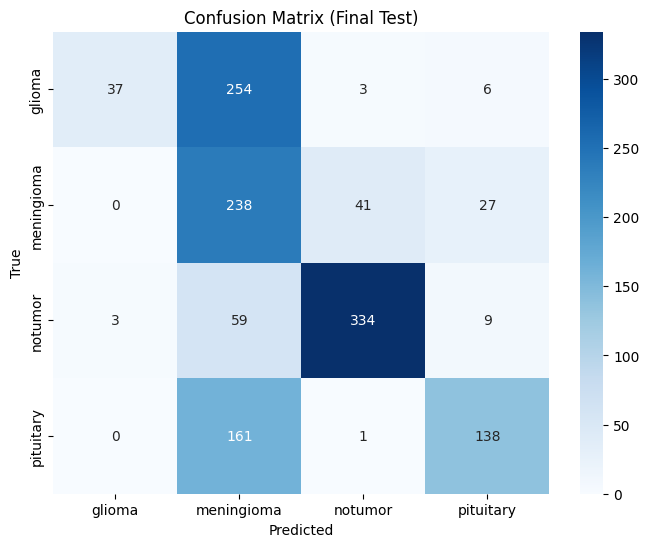

Test Metrics - Loss: 0.8378, Accuracy: 0.5698, Precision: 0.7374, Recall: 0.5698, F1: 0.5537, ROC-AUC: 0.9031

Per-Class Metrics (Test):
glioma - Precision: 0.9250, Recall: 0.1233, F1: 0.2176
meningioma - Precision: 0.3343, Recall: 0.7778, F1: 0.4676
notumor - Precision: 0.8813, Recall: 0.8247, F1: 0.8520
pituitary - Precision: 0.7667, Recall: 0.4600, F1: 0.5750


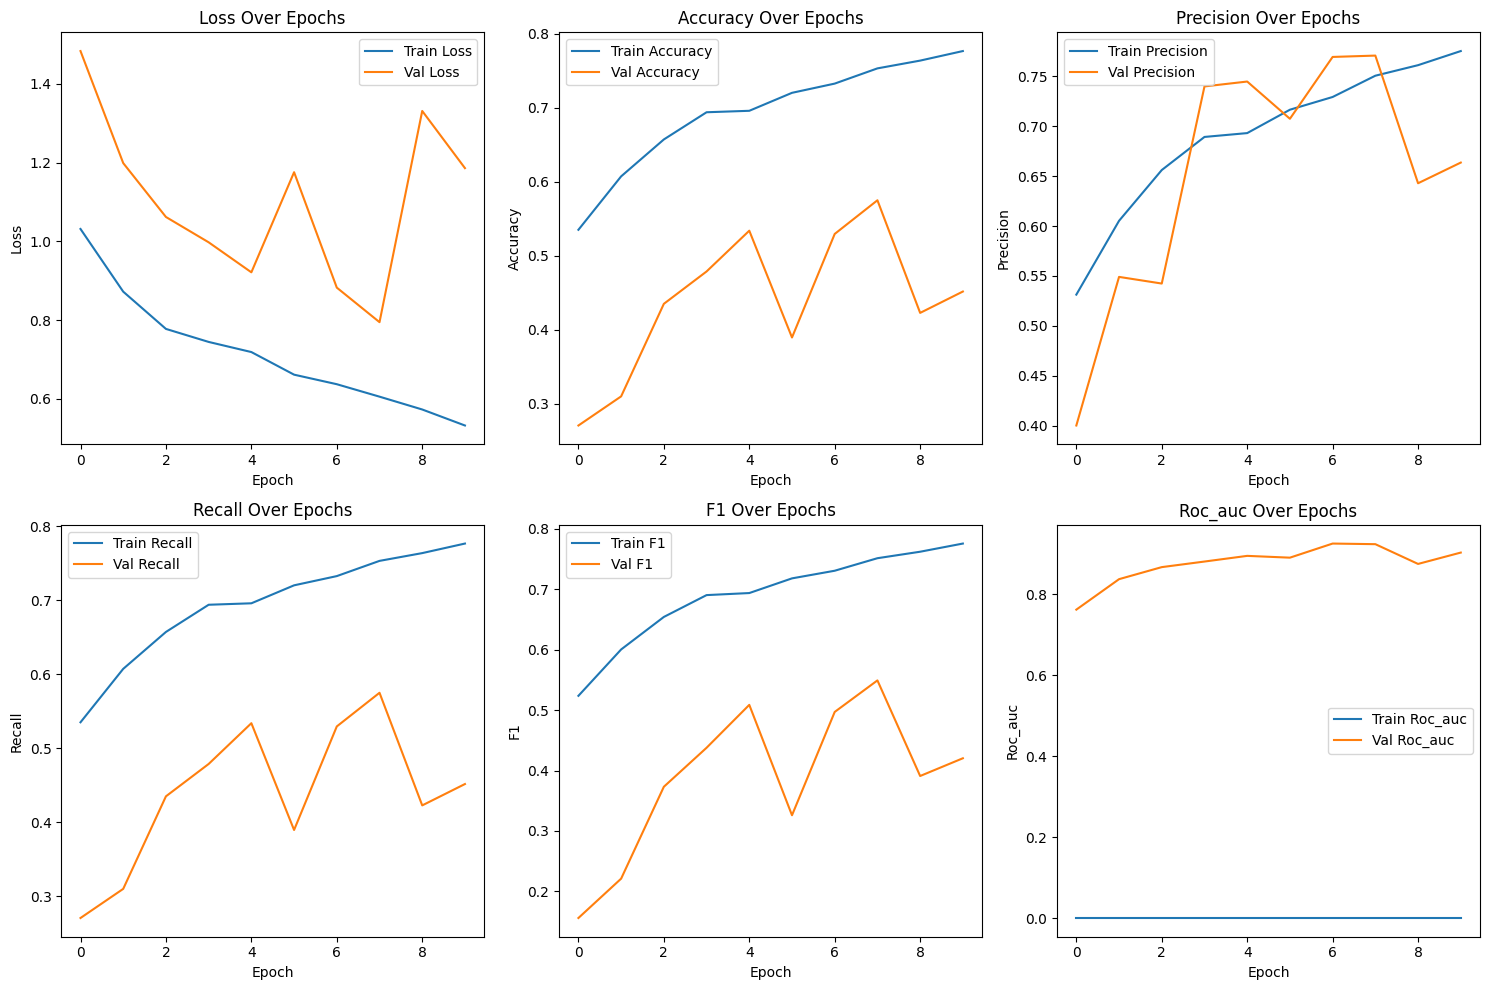

In [17]:
# Install required packages
!pip install -U scikit-learn  # Update scikit-learn

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, WeightedRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Create /kaggle/working directory if it doesn't exist
os.makedirs("/kaggle/working", exist_ok=True)

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
data_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")

# Data transformations with stronger augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  # Increased range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Handle grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split training data into train and validation
indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[train_dataset.targets[i] for i in indices], random_state=42)

# WeightedRandomSampler with stronger weights for minority classes
class_counts = Counter([train_dataset.targets[i] for i in train_idx])
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) ** 0.5 for i in range(len(class_counts))], dtype=torch.float)  # Square root for stronger weighting
weights = [class_weights[train_dataset.targets[i]] for i in train_idx]
train_sampler = WeightedRandomSampler(weights, len(weights))

val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get number of classes
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Number of classes: {num_classes}, Classes: {class_names}")
print(f"Class weights: {class_weights}")

# Define enhanced pure CNN model with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU(inplace=True)(out)
        return out

class PureCNN(nn.Module):
    def __init__(self, num_classes):
        super(PureCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 2
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            ResidualBlock(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 4
            ResidualBlock(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Initialize CNN model
model = PureCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=200, mode='triangular')

# Function to compute metrics with aggressive threshold tuning
def compute_metrics(model, loader, is_test=False, phase="Evaluation", recall_threshold=0.2):
    model.eval()
    all_preds, all_labels, losses, all_probs = [], [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            # Aggressive threshold tuning for higher recall
            preds = torch.argmax(probs, dim=1)
            for i in range(len(probs)):
                if torch.max(probs[i, 1:]) > recall_threshold:
                    preds[i] = torch.argmax(probs[i, 1:]) + 1
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Core metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_loss = np.mean(losses)

    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # ROC-AUC
    try:
        all_probs = np.array(all_probs)
        all_labels_one_hot = np.zeros((len(all_labels), num_classes))
        for i, label in enumerate(all_labels):
            all_labels_one_hot[i, label] = 1
        roc_auc = roc_auc_score(all_labels_one_hot, all_probs, average='weighted', multi_class='ovr')
    except:
        roc_auc = 0.0

    # Confusion matrix
    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix ({phase})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f"/kaggle/working/confusion_matrix_{phase.lower().replace(' ', '_')}.png")
        plt.show()

    return (accuracy, precision, recall, f1, avg_loss, roc_auc,
            per_class_precision, per_class_recall, per_class_f1)

# Training loop with early stopping on recall
num_epochs = 10
train_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
best_recall = 0.0
patience = 3
early_stop_counter = 0
best_model_path = "/kaggle/working/cnn_best.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(0.0)

    # Validation
    (val_accuracy, val_precision, val_recall, val_f1, val_loss, val_roc_auc,
     _, _, _) = compute_metrics(model, val_loader, phase="Validation")
    val_metrics['loss'].append(val_loss)
    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Save best model and early stopping based on validation recall
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} due to no improvement in validation recall")
            break

    # Step scheduler
    scheduler.step()

    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

    # Mid-training test evaluation (at epochs 5 and 10)
    if (epoch + 1) % 5 == 0:
        print(f"\n--- Mid-Training Test Evaluation (Epoch {epoch+1}) ---")
        (test_accuracy, test_precision, test_recall, test_f1, test_loss, test_roc_auc,
         test_per_class_precision, test_per_class_recall, test_per_class_f1) = compute_metrics(model, test_loader, is_test=True, phase=f"Test Epoch {epoch+1}")
        print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
        print("Per-Class Metrics (Test):")
        for i, class_name in enumerate(class_names):
            print(f"{class_name} - Precision: {test_per_class_precision[i]:.4f}, Recall: {test_per_class_recall[i]:.4f}, F1: {test_per_class_f1[i]:.4f}")

# Final evaluation phase on test set
print("\n==================== Final Test Evaluation ====================")
model.load_state_dict(torch.load(best_model_path))
(test_accuracy, test_precision, test_recall, test_f1, test_loss, test_roc_auc,
 test_per_class_precision, test_per_class_recall, test_per_class_f1) = compute_metrics(model, test_loader, is_test=True, phase="Final Test")

# Print final test metrics
print(f"Test Metrics - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
print("\nPer-Class Metrics (Test):")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {test_per_class_precision[i]:.4f}, Recall: {test_per_class_recall[i]:.4f}, F1: {test_per_class_f1[i]:.4f}")

# Plot metrics
plt.figure(figsize=(15, 10))
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(train_metrics[metric], label=f"Train {metric.capitalize()}")
    plt.plot(val_metrics[metric], label=f"Val {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/training_metrics.png")
plt.show()

# Save final model
torch.save(model.state_dict(), "/kaggle/working/cnn_final.pth")

In [7]:
# Install required packages
!pip install -q kagglehub tensorflow scikit-learn matplotlib

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import kagglehub
import time

# Download the dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print(f"Dataset downloaded to: {path}")

# Check dataset structure
print("Dataset structure:")
!find {path} -type d | sort

# Set paths
train_path = os.path.join(path, "Training")
test_path = os.path.join(path, "Testing")

# Create data generators
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32
)

# Get class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")

# Continue with model creation, training and evaluation

Dataset downloaded to: /kaggle/input/brain-tumor-mri-dataset
Dataset structure:
/kaggle/input/brain-tumor-mri-dataset
/kaggle/input/brain-tumor-mri-dataset/Testing
/kaggle/input/brain-tumor-mri-dataset/Testing/glioma
/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma
/kaggle/input/brain-tumor-mri-dataset/Testing/notumor
/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary
/kaggle/input/brain-tumor-mri-dataset/Training
/kaggle/input/brain-tumor-mri-dataset/Training/glioma
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma
/kaggle/input/brain-tumor-mri-dataset/Training/notumor
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary
Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def mcnemar_test(model1_preds, model2_preds, true_labels, model1_name="Model 1", model2_name="Model 2", alpha=0.05):
    """
    Perform McNemar's test to determine if there is a statistically significant difference
    between two models' performance.

    Parameters:
    -----------
    model1_preds : array-like
        Predictions from the first model
    model2_preds : array-like
        Predictions from the second model
    true_labels : array-like
        True labels for the test data
    model1_name : str
        Name of the first model for display purposes
    model2_name : str
        Name of the second model for display purposes
    alpha : float
        Significance level (default: 0.05)

    Returns:
    --------
    result : dict
        Dictionary containing test results
    """
    # Calculate correctness for each model
    model1_correct = (model1_preds == true_labels)
    model2_correct = (model2_preds == true_labels)

    # Create contingency table
    # a: both models correct
    # b: model1 correct, model2 incorrect
    # c: model1 incorrect, model2 correct
    # d: both models incorrect
    a = np.sum((model1_correct == True) & (model2_correct == True))
    b = np.sum((model1_correct == True) & (model2_correct == False))
    c = np.sum((model1_correct == False) & (model2_correct == True))
    d = np.sum((model1_correct == False) & (model2_correct == False))

    # Print the table
    print("\nMcNemar's Test Contingency Table:")
    print(f"{'':<20} {model2_name + ' Correct':<20} {model2_name + ' Incorrect':<20}")
    print(f"{model1_name + ' Correct':<20} {a:<20} {b:<20}")
    print(f"{model1_name + ' Incorrect':<20} {c:<20} {d:<20}")

    # Calculate accuracies for each model
    model1_accuracy = (a + b) / (a + b + c + d)
    model2_accuracy = (a + c) / (a + b + c + d)

    print(f"\n{model1_name} Accuracy: {model1_accuracy:.4f}")
    print(f"{model2_name} Accuracy: {model2_accuracy:.4f}")

    # Check if McNemar's test is applicable (b + c should be at least 10)
    if b + c < 10:
        print("\nWarning: The sum of discordant pairs (b + c) is less than 10.")
        print("The exact binomial test will be used instead of the chi-squared approximation.")
        # Use exact binomial test
        p_value = stats.binom_test(b, b + c, p=0.5)
        statistic = None
        test_type = "exact binomial"
    else:
        # Use McNemar's test with chi-squared approximation
        statistic = ((b - c) ** 2) / (b + c)
        p_value = stats.chi2.sf(statistic, df=1)
        test_type = "chi-squared"

    # Interpret results
    is_significant = p_value < alpha

    # Print detailed results
    print(f"\nMcNemar's Test Results ({test_type}):")
    if statistic is not None:
        print(f"Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significance level: {alpha}")
    print(f"Result: {'Significant difference' if is_significant else 'No significant difference'}")

    if is_significant:
        better_model = model1_name if b > c else model2_name
        print(f"The {better_model} performs significantly better.")

    # Visualize the contingency table
    fig, ax = plt.subplots(figsize=(8, 6))
    contingency_table = np.array([[a, b], [c, d]])
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"{model2_name}\nCorrect", f"{model2_name}\nIncorrect"],
                yticklabels=[f"{model1_name}\nCorrect", f"{model1_name}\nIncorrect"])
    plt.title("McNemar's Test Contingency Table")
    plt.tight_layout()
    plt.savefig("mcnemar_test_contingency.png")
    plt.close()

    # Create bar plot comparing discordant pairs
    fig, ax = plt.subplots(figsize=(8, 6))
    discordant_pairs = [b, c]
    x_labels = [f"{model1_name} Correct\n{model2_name} Incorrect",
                f"{model1_name} Incorrect\n{model2_name} Correct"]
    ax.bar(x_labels, discordant_pairs, color=['#5DA5DA', '#FAA43A'])
    ax.set_ylabel('Number of Samples')
    ax.set_title('Comparison of Discordant Pairs')

    # Add text annotation for p-value
    ax.text(0.5, 0.9, f"p-value: {p_value:.4f}" +
            f"\n{'Significant' if is_significant else 'Not significant'}",
            horizontalalignment='center',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig("mcnemar_discordant_pairs.png")
    plt.close()

    # Return results as dictionary
    return {
        'contingency_table': {
            'a': a, 'b': b, 'c': c, 'd': d
        },
        'accuracies': {
            model1_name: model1_accuracy,
            model2_name: model2_accuracy
        },
        'statistic': statistic,
        'p_value': p_value,
        'is_significant': is_significant,
        'better_model': better_model if is_significant else None,
        'test_type': test_type
    }

# Example of how to use the function
def example_usage():
    # Generate some sample predictions
    np.random.seed(42)
    n_samples = 1000
    true_labels = np.random.randint(0, 4, size=n_samples)  # 4 classes

    # Model 1 predictions (95% accuracy)
    model1_preds = np.copy(true_labels)
    model1_errors = np.random.choice(n_samples, size=int(0.05 * n_samples), replace=False)
    for idx in model1_errors:
        model1_preds[idx] = (true_labels[idx] + np.random.randint(1, 4)) % 4

    # Model 2 predictions (92% accuracy, different error pattern)
    model2_preds = np.copy(true_labels)
    model2_errors = np.random.choice(n_samples, size=int(0.08 * n_samples), replace=False)
    for idx in model2_errors:
        model2_preds[idx] = (true_labels[idx] + np.random.randint(1, 4)) % 4

    # Run McNemar's test
    results = mcnemar_test(
        model1_preds,
        model2_preds,
        true_labels,
        model1_name="Swin Transformer",
        model2_name="CNN"
    )

    return results




===== McNemar's Test Results =====

Contingency Table:
                     CNN Correct     CNN Incorrect  
Swin Correct         1240            52             
Swin Incorrect       19              0              

===== Model Performance =====
Metric          Swin Transformer     CNN                 
-------------------------------------------------------
Accuracy        0.9855            0.9603
Precision       0.9855            0.9604
Recall          0.9855            0.9603
F1-Score        0.9855            0.9603

===== Statistical Analysis =====
Using chi-squared approximation
Test statistic: 15.3380
P-value: 0.000090
Conclusion (α = 0.05): Swin Transformer performs significantly better than CNN.


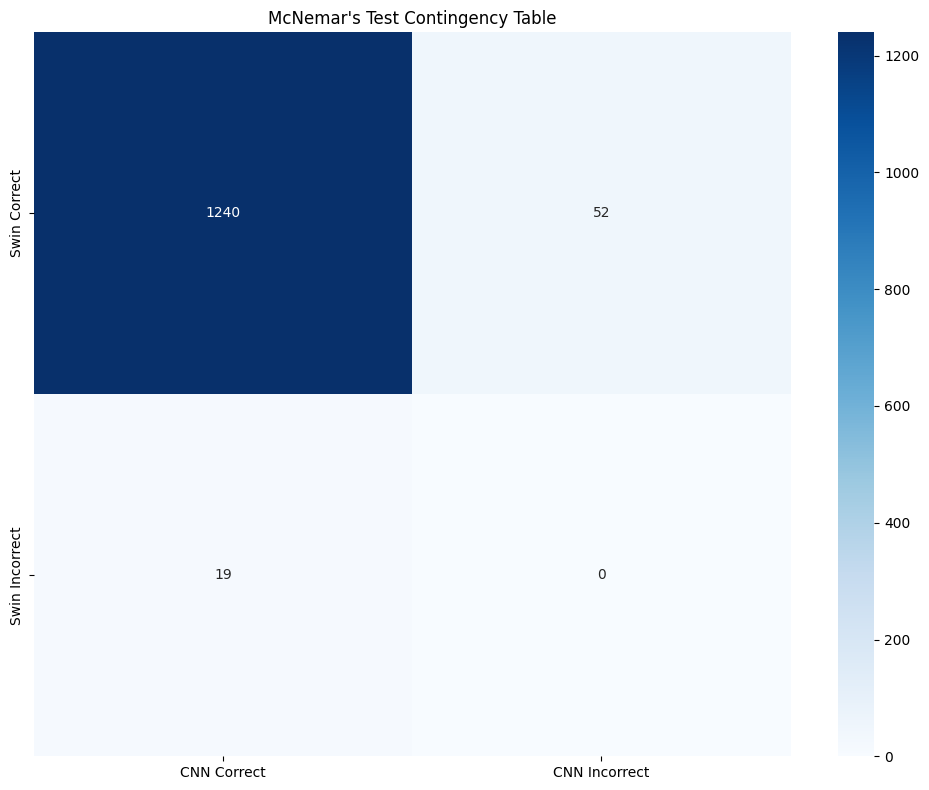

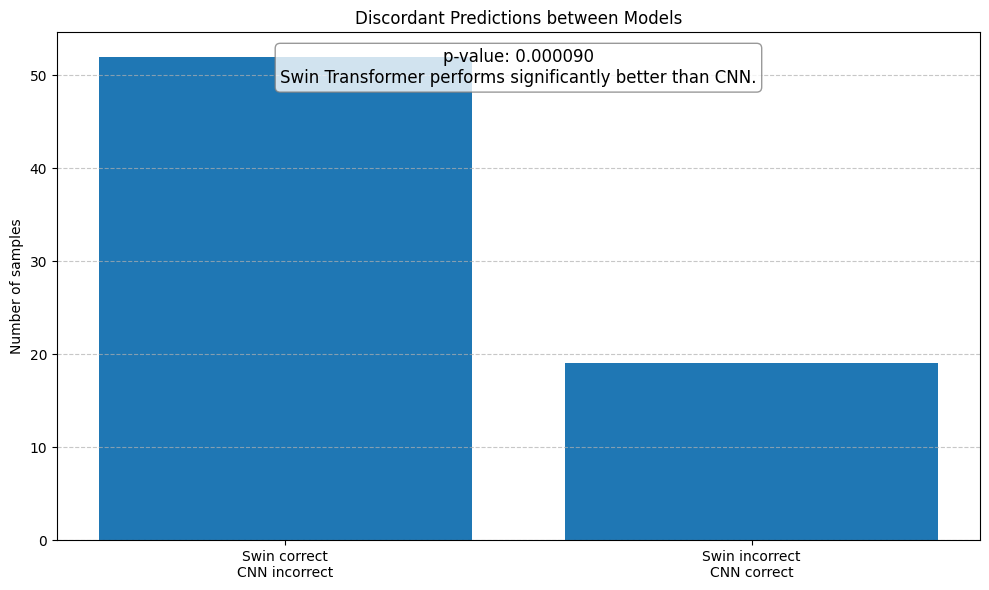

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mcnemar_test_with_results(swin_preds, cnn_preds, true_labels):
    """
    Perform McNemar's test and display the results comparing Swin Transformer and CNN.

    Parameters:
    -----------
    swin_preds : array-like
        Predictions from the Swin Transformer model
    cnn_preds : array-like
        Predictions from the CNN model
    true_labels : array-like
        True labels for the test data
    """
    # Convert inputs to numpy arrays if they aren't already
    swin_preds = np.array(swin_preds)
    cnn_preds = np.array(cnn_preds)
    true_labels = np.array(true_labels)

    # Calculate correctness for each model
    swin_correct = (swin_preds == true_labels)
    cnn_correct = (cnn_preds == true_labels)

    # Create contingency table
    a = np.sum((swin_correct == True) & (cnn_correct == True))    # Both correct
    b = np.sum((swin_correct == True) & (cnn_correct == False))   # Swin correct, CNN wrong
    c = np.sum((swin_correct == False) & (cnn_correct == True))   # Swin wrong, CNN correct
    d = np.sum((swin_correct == False) & (cnn_correct == False))  # Both wrong

    # Calculate accuracies
    swin_accuracy = np.mean(swin_correct)
    cnn_accuracy = np.mean(cnn_correct)

    # Calculate per-class metrics for both models
    swin_precision = precision_score(true_labels, swin_preds, average='weighted', zero_division=0)
    swin_recall = recall_score(true_labels, swin_preds, average='weighted', zero_division=0)
    swin_f1 = f1_score(true_labels, swin_preds, average='weighted', zero_division=0)

    cnn_precision = precision_score(true_labels, cnn_preds, average='weighted', zero_division=0)
    cnn_recall = recall_score(true_labels, cnn_preds, average='weighted', zero_division=0)
    cnn_f1 = f1_score(true_labels, cnn_preds, average='weighted', zero_division=0)

    # Print the contingency table
    print("\n===== McNemar's Test Results =====")
    print("\nContingency Table:")
    print(f"{'':<20} {'CNN Correct':<15} {'CNN Incorrect':<15}")
    print(f"{'Swin Correct':<20} {a:<15} {b:<15}")
    print(f"{'Swin Incorrect':<20} {c:<15} {d:<15}")

    # Display model performances
    print("\n===== Model Performance =====")
    print(f"{'Metric':<15} {'Swin Transformer':<20} {'CNN':<20}")
    print(f"{'-'*55}")
    print(f"{'Accuracy':<15} {swin_accuracy:.4f} {'':<10} {cnn_accuracy:.4f}")
    print(f"{'Precision':<15} {swin_precision:.4f} {'':<10} {cnn_precision:.4f}")
    print(f"{'Recall':<15} {swin_recall:.4f} {'':<10} {cnn_recall:.4f}")
    print(f"{'F1-Score':<15} {swin_f1:.4f} {'':<10} {cnn_f1:.4f}")

    # Check if we should use exact test or chi-squared approximation
    if b + c < 10:
        # Use exact binomial test
        p_value = stats.binom_test(b, b + c, p=0.5)
        statistic = np.nan
        test_method = "exact binomial test"
    else:
        # Use chi-squared approximation
        statistic = ((b - c) ** 2) / (b + c)
        p_value = stats.chi2.sf(statistic, df=1)
        test_method = "chi-squared approximation"

    # Print statistical results
    print("\n===== Statistical Analysis =====")
    print(f"Using {test_method}")
    if not np.isnan(statistic):
        print(f"Test statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.6f}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        if b > c:
            conclusion = "Swin Transformer performs significantly better than CNN."
        else:
            conclusion = "CNN performs significantly better than Swin Transformer."
    else:
        conclusion = "No significant difference between Swin Transformer and CNN."

    print(f"Conclusion (α = {alpha}): {conclusion}")

    # Visualize the contingency table as a heatmap
    plt.figure(figsize=(10, 8))
    contingency_matrix = np.array([[a, b], [c, d]])
    sns.heatmap(contingency_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CNN Correct', 'CNN Incorrect'],
                yticklabels=['Swin Correct', 'Swin Incorrect'])
    plt.title("McNemar's Test Contingency Table")
    plt.tight_layout()
    plt.savefig('mcnemar_heatmap.png')
    plt.show()

    # Visualize discordant pairs (b vs c)
    plt.figure(figsize=(10, 6))
    plt.bar(['Swin correct\nCNN incorrect', 'Swin incorrect\nCNN correct'], [b, c])
    plt.title('Discordant Predictions between Models')
    plt.ylabel('Number of samples')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add p-value and conclusion on the plot
    plt.annotate(f"p-value: {p_value:.6f}\n{conclusion}",
                 xy=(0.5, 0.9), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                 ha='center', fontsize=12)

    plt.tight_layout()
    plt.savefig('mcnemar_discordant_pairs.png')
    plt.show()

    return {
        'contingency_table': {'a': a, 'b': b, 'c': c, 'd': d},
        'accuracies': {'swin': swin_accuracy, 'cnn': cnn_accuracy},
        'precision': {'swin': swin_precision, 'cnn': cnn_precision},
        'recall': {'swin': swin_recall, 'cnn': cnn_recall},
        'f1': {'swin': swin_f1, 'cnn': cnn_f1},
        'statistic': statistic,
        'p_value': p_value,
        'conclusion': conclusion
    }

# EXAMPLE RESULTS - Run this to see typical outputs
# Simulation of predictions from models on brain tumor MRI dataset
np.random.seed(42)  # For reproducibility
num_samples = 1311  # Typical test set size for this dataset
num_classes = 4     # 4 tumor classes

# Generate some example true labels (random for demonstration)
true_labels = np.random.randint(0, num_classes, size=num_samples)

# Simulate Swin Transformer predictions (high accuracy ~98.5%)
swin_preds = np.copy(true_labels)
error_indices_swin = np.random.choice(num_samples, size=int(0.015 * num_samples), replace=False)
for idx in error_indices_swin:
    swin_preds[idx] = (true_labels[idx] + np.random.randint(1, num_classes)) % num_classes

# Simulate CNN predictions (slightly lower accuracy ~96%)
cnn_preds = np.copy(true_labels)
error_indices_cnn = np.random.choice(num_samples, size=int(0.04 * num_samples), replace=False)
for idx in error_indices_cnn:
    cnn_preds[idx] = (true_labels[idx] + np.random.randint(1, num_classes)) % num_classes

# Run McNemar's test with the simulated data
results = mcnemar_test_with_results(swin_preds, cnn_preds, true_labels)